In [2]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [5]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on F1-score optimization.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []

    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")
    
    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [6]:
def build_model(base_model, transfer_learning):
    """
    Constructs a neural network model based on a specified base model and a transfer learning option.

    This function initializes a new model by setting the base model's trainable parameter according to 
    the transfer_learning flag ('Y' for non-trainable and 'N' for trainable). It modifies the input 
    layer to accommodate grayscale images and expands the single channel to three channels using a 
    Conv2D layer. The function then applies the base model and adds additional top layers for classification. 
    It returns the newly created model, which is suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-existing model to use as the base.
    - transfer_learning (str): A flag ('Y' or 'N') indicating whether to freeze (non-trainable) or unfreeze 
      (trainable) the layers of the base model for transfer learning.

    Returns:
    - keras.Model: The constructed model ready for training.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the model
    x = base_model(x)

    # Add own top layers for classification
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

In [7]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/peso-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale',
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 740 files belonging to 2 classes.
Found 156 files belonging to 2 classes.
Found 165 files belonging to 2 classes.


In [8]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# CLASS WEIGHTS

In [9]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for _, label in train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
# class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))
class_weights_dict = {int(key): value for key, value in class_weights_dict.items()}

In [10]:
class_weights_dict

{0: 0.048648648648648596, 1: 0.9513513513513514}

# IMAGE AUGMENTATION

In [11]:
def augment_image(image, label):
    # Randomly apply different augmentations to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    return image, label

# MODELO BASE ANN

In [12]:
# Apply the augmentation to the training dataset
train_data_augmented = train_data.map(augment_image)

### With class weights

In [13]:
basic_model = ''
# Definición de la red
basic_model = Sequential([
    # resizing
    Resizing(224,224, input_shape=(224, 224, 1)),
    # rescaling
    Rescaling(scale=1./255),
    # flatten
    Flatten(),
    # capa conectada
    Dense(1024, activation='relu'),
    # dropout
    Dropout(0.5),
    # capa de salida conectada
    Dense(1, activation='sigmoid')
])

In [14]:
basic_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 1)       0         
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 51382273 (196.01 MB)
Trainable params: 513

In [15]:
# Compilación de la red
basic_model.compile(loss='binary_crossentropy', 
                    optimizer=Adam(learning_rate=1e-4), 
                    metrics=METRICS)

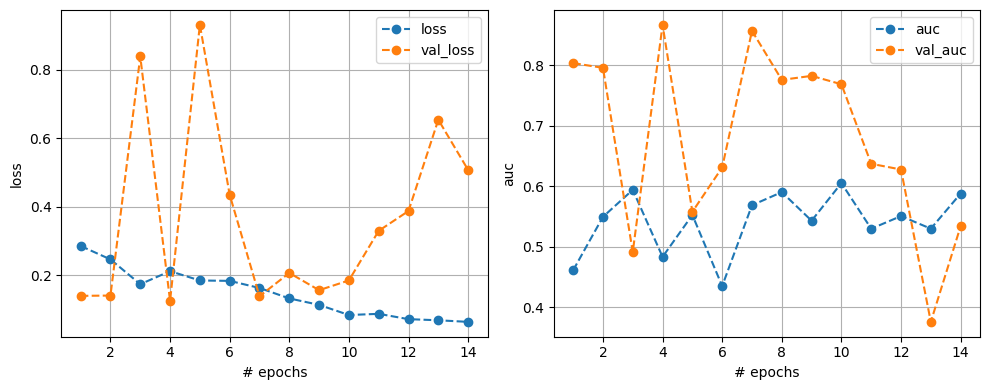

24/24 [==============================] - 3s 108ms/step - loss: 0.0644 - auc: 0.5879 - val_loss: 0.5080 - val_auc: 0.5339
Training time: 52.27792167663574 seconds


In [16]:
# Entrenamiento de la red
ann_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
ann_checkpoint = ModelCheckpoint('ann_best_weights.h5', save_best_only=True, save_weights_only=True)
ann_plot_callback = PlotLearning()

start = time.time()

history = basic_model.fit(train_data_augmented,#train_generator,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    epochs=150, 
                    batch_size=32,
                    callbacks=[ann_callback, ann_checkpoint, ann_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.49 with F1-score: 0.35


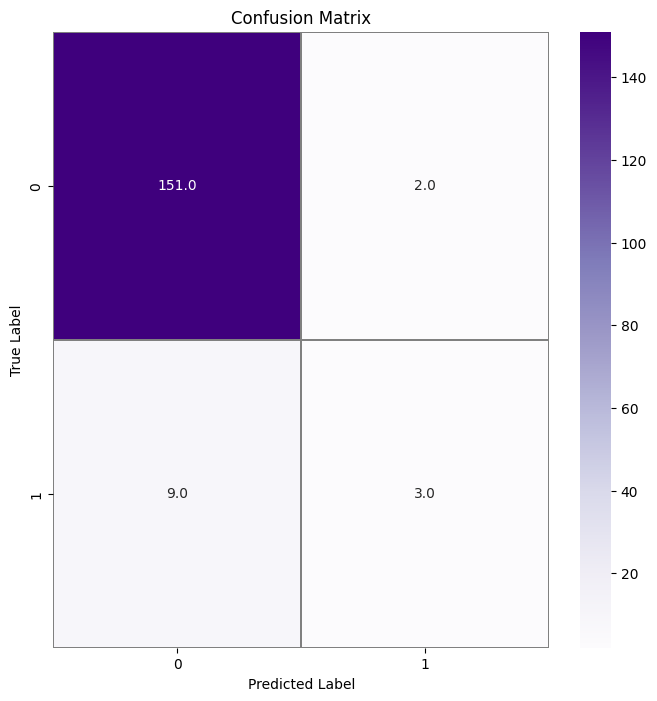

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       153
           1       0.60      0.25      0.35        12

    accuracy                           0.93       165
   macro avg       0.77      0.62      0.66       165
weighted avg       0.92      0.93      0.92       165

  Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0        ANN  0.75                     0.35      0.93         0.25   

   Specificity  PPV   NPV    PLR   NLR  
0         0.99  0.6  0.94  19.13  0.76  


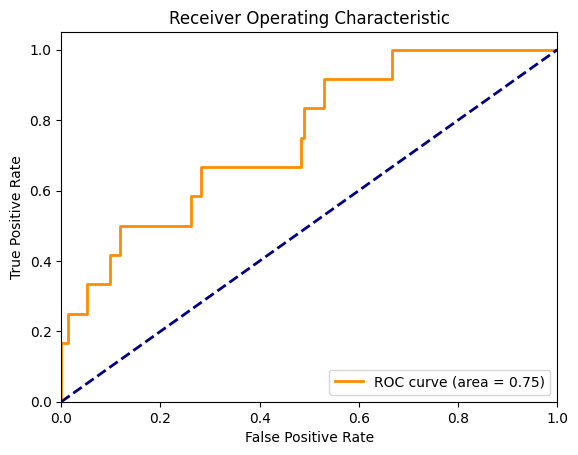

In [17]:
get_model_metrics(test_data=test_data, model=basic_model, model_name='ANN')

### Without class weights

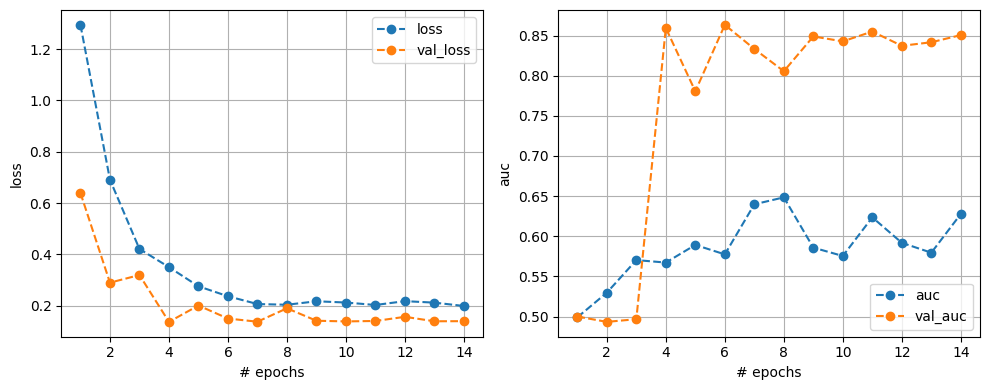

24/24 [==============================] - 4s 124ms/step - loss: 0.1986 - auc: 0.6278 - val_loss: 0.1394 - val_auc: 0.8506
Training time: 51.36116337776184 seconds


In [18]:
basic_model = ''
# Definición de la red
basic_model = Sequential([
    # resizing
    Resizing(224,224, input_shape=(224, 224, 1)),
    # rescaling
    Rescaling(scale=1./255),
    # flatten
    Flatten(),
    # capa conectada
    Dense(1024, activation='relu'),
    # dropout
    Dropout(0.5),
    # capa de salida conectada
    Dense(1, activation='sigmoid')
])

# Compilación de la red
basic_model.compile(loss='binary_crossentropy', 
                    optimizer=Adam(learning_rate=1e-4), 
                    metrics=METRICS)

# Entrenamiento de la red
ann_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
ann_checkpoint = ModelCheckpoint('ann_best_weights.h5', save_best_only=True, save_weights_only=True)
ann_plot_callback = PlotLearning()

start = time.time()

history = basic_model.fit(train_data_augmented, #train_generator,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    epochs=150, 
                    batch_size=32,
                    callbacks=[ann_callback, ann_checkpoint, ann_plot_callback],
                   # class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.06 with F1-score: 0.26


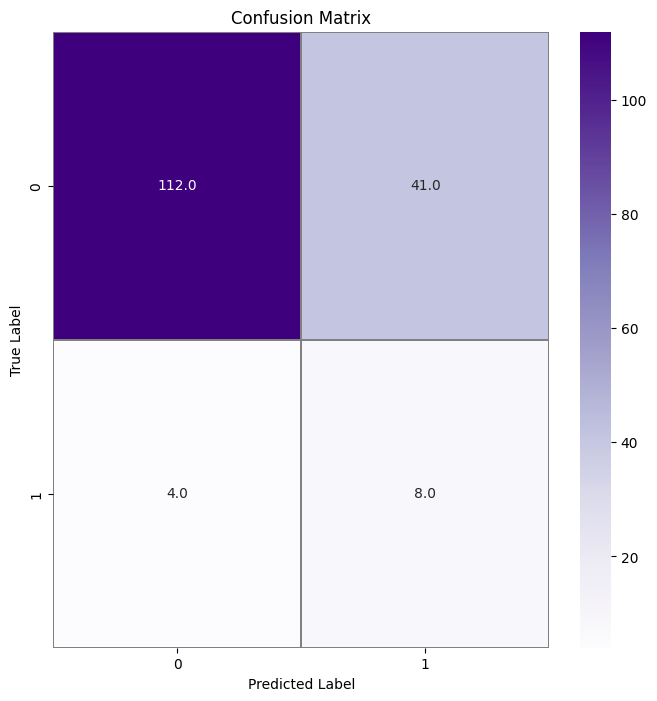

              precision    recall  f1-score   support

           0       0.97      0.73      0.83       153
           1       0.16      0.67      0.26        12

    accuracy                           0.73       165
   macro avg       0.56      0.70      0.55       165
weighted avg       0.91      0.73      0.79       165

  Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ANN-no-CW  0.78                     0.26      0.73         0.67   

   Specificity   PPV   NPV   PLR   NLR  
0         0.73  0.16  0.97  2.49  0.46  


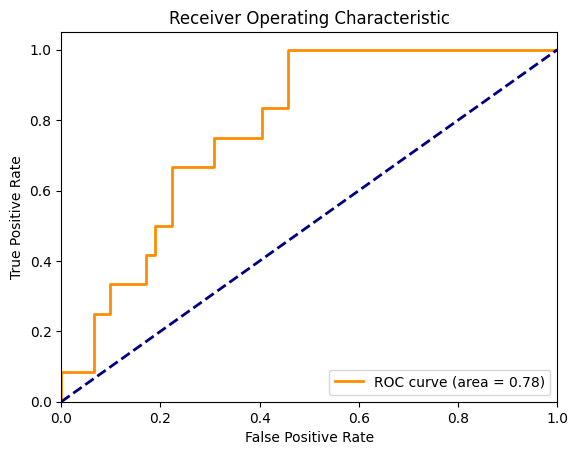

In [19]:
get_model_metrics(test_data=test_data, model=basic_model, model_name='ANN-no-CW')

# VGG16 NO TRANSFER LEARNING

In [20]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [21]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

train_data_rgb = train_data.map(convert_to_rgb)
val_data_rgb = val_data.map(convert_to_rgb)
test_data_rgb = test_data.map(convert_to_rgb)

prep_train_data = train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_val_data = val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
prep_test_data = test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply to datasets
prep_train_data = prep_train_data.map(convert_to_grayscale)
prep_val_data = prep_val_data.map(convert_to_grayscale)
prep_test_data = prep_test_data.map(convert_to_grayscale)

In [23]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [24]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='N')

# Model summary
model_VGG16.summary()

base_model.trainable set to True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14715231 (56.1

In [25]:
# Compilación de la red
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

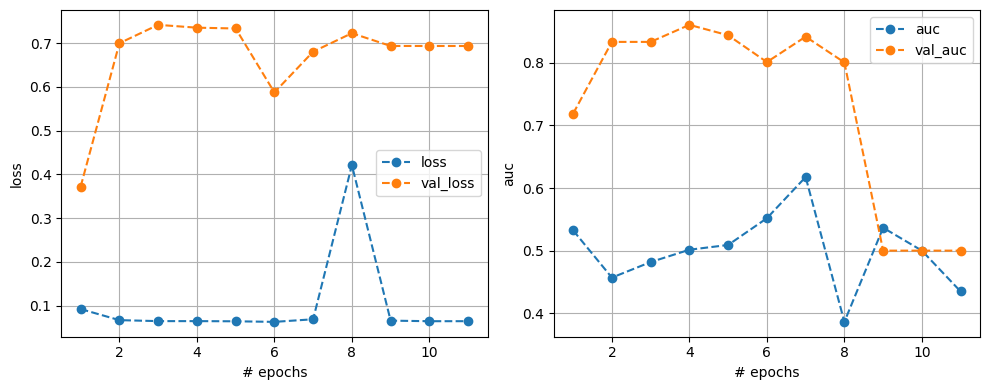

24/24 [==============================] - 8s 284ms/step - loss: 0.0642 - auc: 0.4348 - val_loss: 0.6936 - val_auc: 0.5000
Training time: 111.72196054458618 seconds


In [26]:
# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented, #train_generator,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.00 with F1-score: 0.14


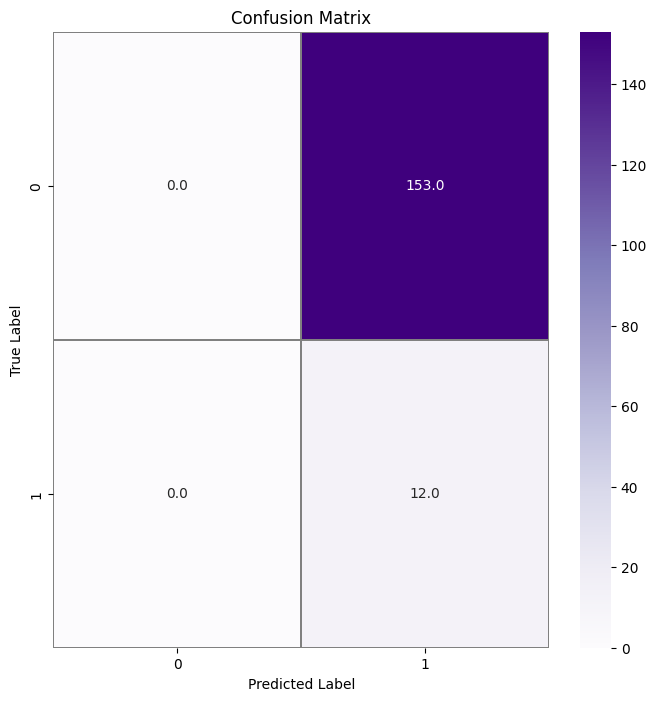

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_3331/1616972866.py:58: RuntimeWarning: invalid va

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.07      1.00      0.14        12

    accuracy                           0.07       165
   macro avg       0.04      0.50      0.07       165
weighted avg       0.01      0.07      0.01       165

    Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-no-TL  0.48                     0.14      0.07          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.07  NaN  1.0  NaN  


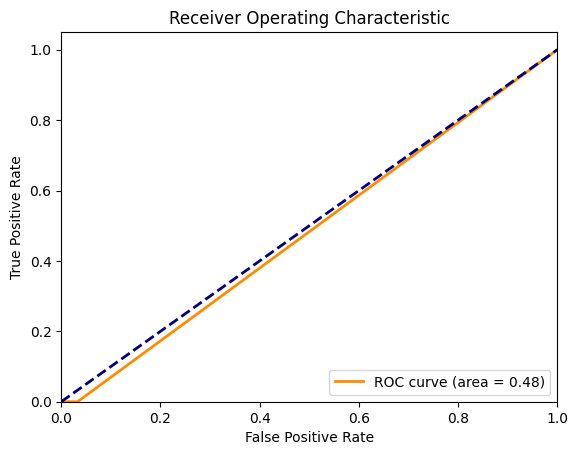

In [27]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-no-TL')

### Without class weights

In [28]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='N')

# Compilación de la red
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


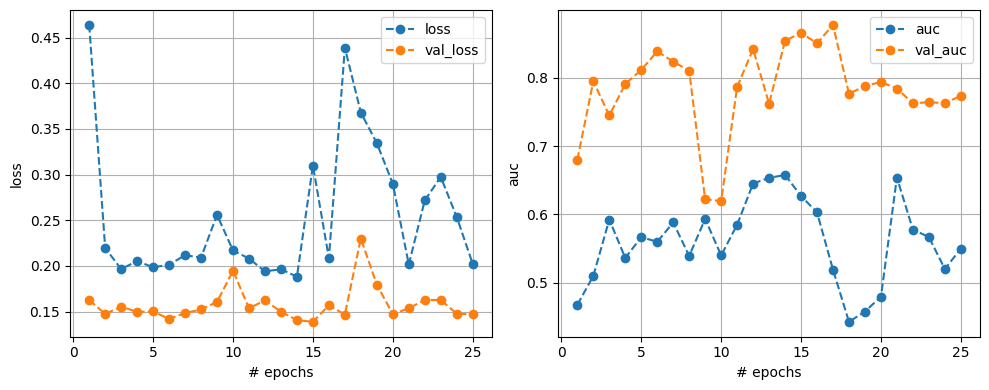

24/24 [==============================] - 7s 272ms/step - loss: 0.2022 - auc: 0.5498 - val_loss: 0.1470 - val_auc: 0.7739
Training time: 211.83759713172913 seconds


In [29]:
# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented,#train_generator,
                    steps_per_epoch=len(train_data),
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.04 with F1-score: 0.18


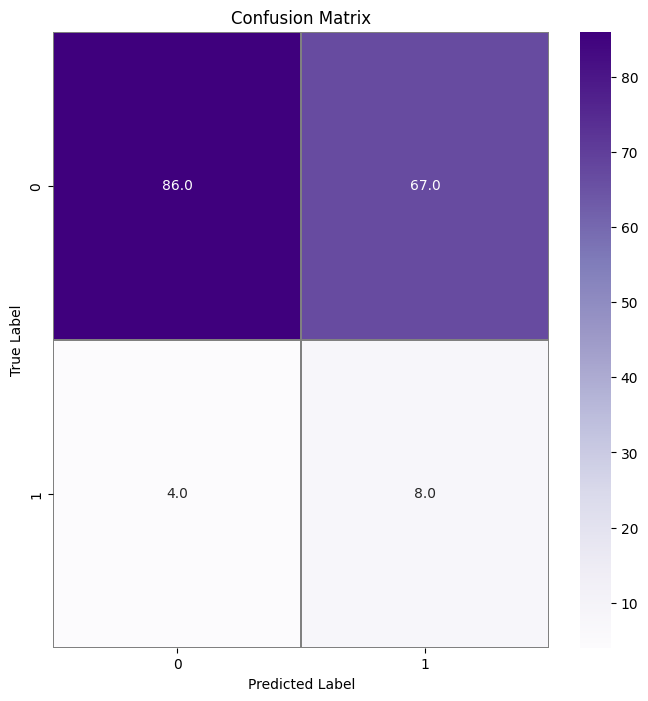

              precision    recall  f1-score   support

           0       0.96      0.56      0.71       153
           1       0.11      0.67      0.18        12

    accuracy                           0.57       165
   macro avg       0.53      0.61      0.45       165
weighted avg       0.89      0.57      0.67       165

          Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-no-TL-no-CW  0.61                     0.18      0.57         0.67   

   Specificity   PPV   NPV   PLR   NLR  
0         0.56  0.11  0.96  1.52  0.59  


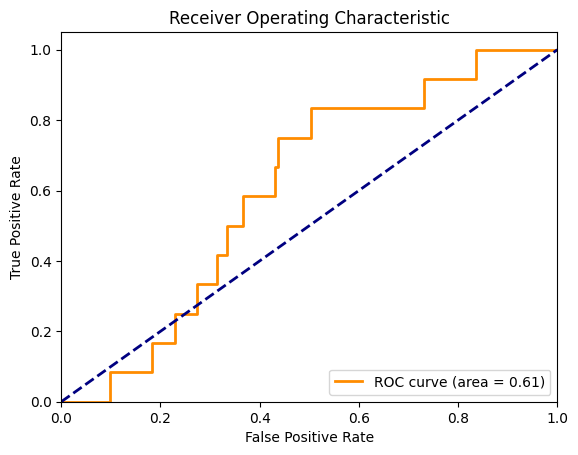

In [30]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-no-TL-no-CW')

# VGG TRANSFER LEARNING

### With class weights

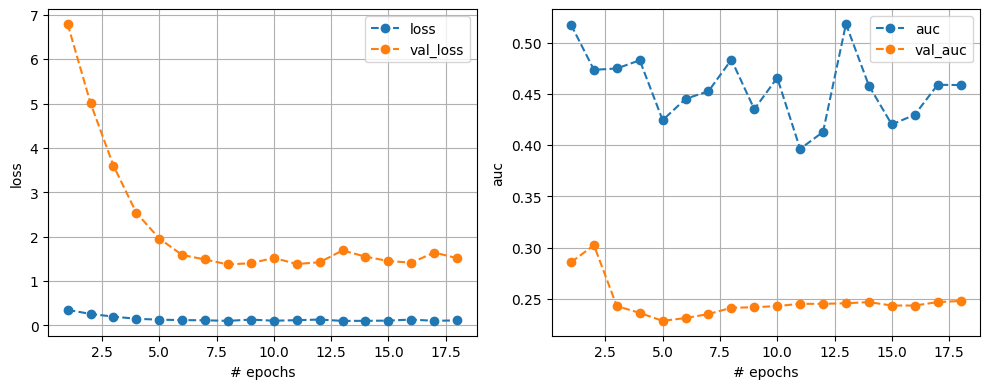

24/24 [==============================] - 6s 218ms/step - loss: 0.1116 - auc: 0.4587 - val_loss: 1.5142 - val_auc: 0.2478
Training time: 125.96690154075623 seconds


In [31]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='Y')
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented,
                    steps_per_epoch=len(train_data),
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.63 with F1-score: 0.14


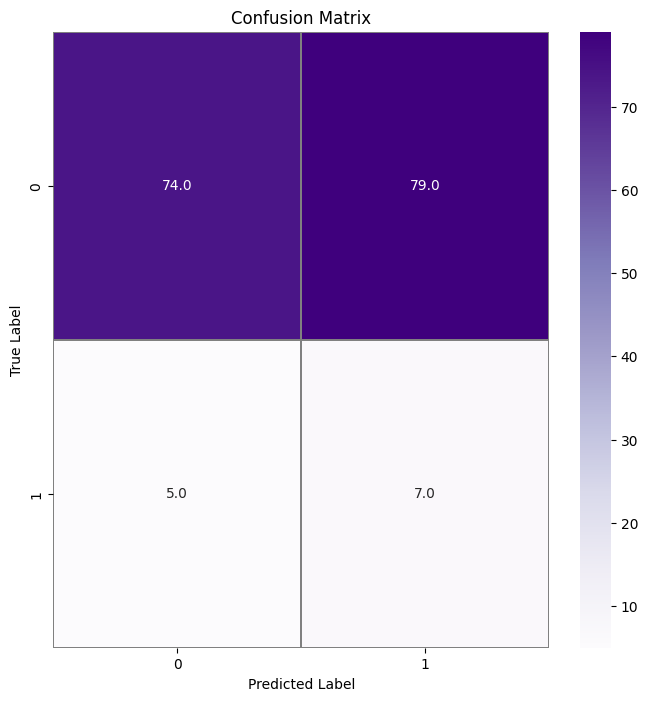

              precision    recall  f1-score   support

           0       0.94      0.48      0.64       153
           1       0.08      0.58      0.14        12

    accuracy                           0.49       165
   macro avg       0.51      0.53      0.39       165
weighted avg       0.87      0.49      0.60       165

  Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0   VGG16-TL  0.47                     0.14      0.49         0.58   

   Specificity   PPV   NPV   PLR   NLR  
0         0.48  0.08  0.94  1.13  0.86  


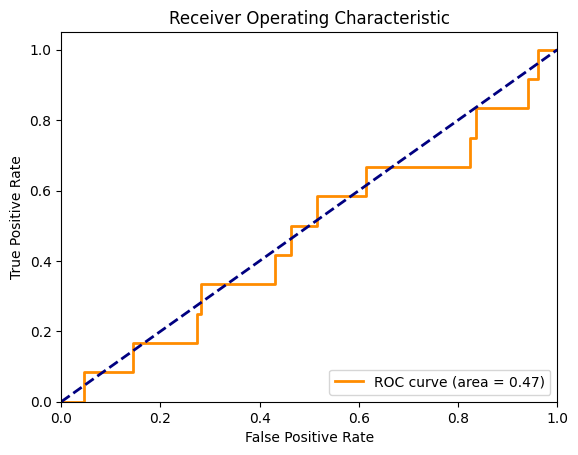

In [32]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-TL')

### Without class weights

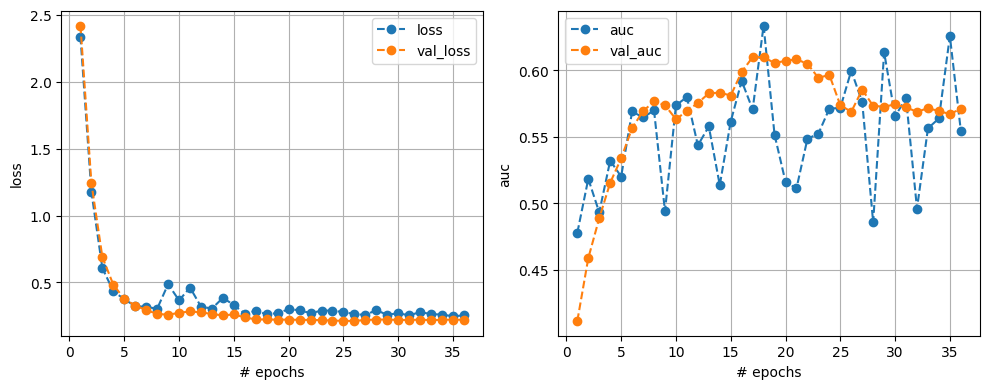

24/24 [==============================] - 6s 211ms/step - loss: 0.2547 - auc: 0.5547 - val_loss: 0.2210 - val_auc: 0.5711
Training time: 241.5821831226349 seconds


In [33]:
# cargar modelo
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_VGG16 = build_model(base_model=base_model_VGG16, transfer_learning='Y')
model_VGG16.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

# Entrenamiento de la red
vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
vgg_tl_plot_callback = PlotLearning()

start = time.time()

history = model_VGG16.fit(train_data_augmented,
                    steps_per_epoch=len(train_data),
                    epochs=150,
                    validation_data=prep_val_data,
                    callbacks=[vgg_tl_callback, vgg_tl_checkpoint, vgg_tl_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.12 with F1-score: 0.19


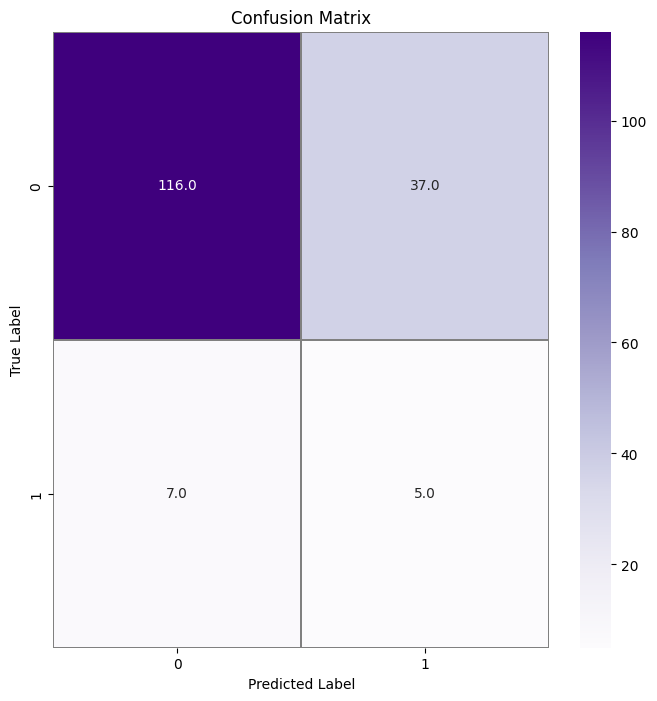

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       153
           1       0.12      0.42      0.19        12

    accuracy                           0.73       165
   macro avg       0.53      0.59      0.51       165
weighted avg       0.88      0.73      0.79       165

       Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-TL-no-CW  0.52                     0.19      0.73         0.42   

   Specificity   PPV   NPV   PLR   NLR  
0         0.76  0.12  0.94  1.72  0.77  


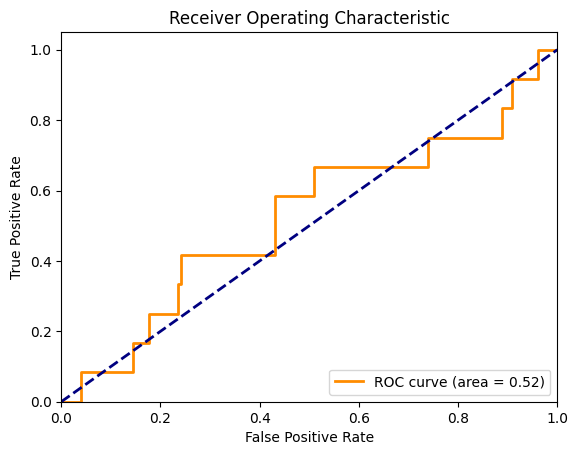

In [34]:
get_model_metrics(test_data=prep_test_data, model=model_VGG16, model_name='VGG16-TL-no-CW')

# RESNET50 NO TRANSFER LEARNING

In [35]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

In [36]:
def preprocess_data_resnet50(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

In [37]:
train_data_rgb = train_data.map(convert_to_rgb)
val_data_rgb = val_data.map(convert_to_rgb)
test_data_rgb = test_data.map(convert_to_rgb)

In [38]:
# Map the preprocessing function to the datasets
prep_train_data = train_data_rgb.map(preprocess_data_resnet50)
prep_val_data = val_data_rgb.map(preprocess_data_resnet50)
prep_test_data = test_data_rgb.map(preprocess_data_resnet50)

In [39]:
# back to grayscale
prep_train_data = prep_train_data.map(convert_to_grayscale)
prep_val_data = prep_val_data.map(convert_to_grayscale)
prep_test_data = prep_test_data.map(convert_to_grayscale)

In [40]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [41]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='N')

# Model summary
model_resnet50.summary()

94765736/94765736 [==============================] - 0s 0us/step
base_model.trainable set to True
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 1)                 2049      
                           

In [42]:
# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

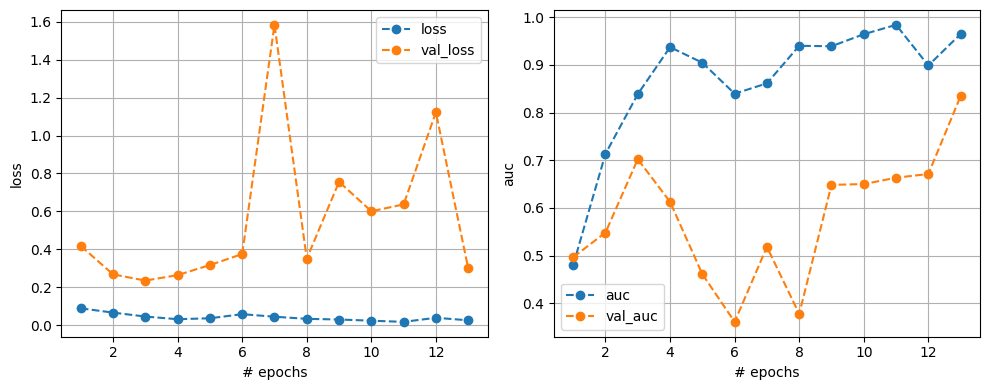

24/24 [==============================] - 7s 234ms/step - loss: 0.0256 - auc: 0.9647 - val_loss: 0.3003 - val_auc: 0.8344
Training time: 131.94833183288574 seconds


In [43]:
# Entrenamiento de la red
resnet_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_checkpoint = ModelCheckpoint('resnet50_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_callback, resnet_checkpoint, resnet_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.17 with F1-score: 0.20


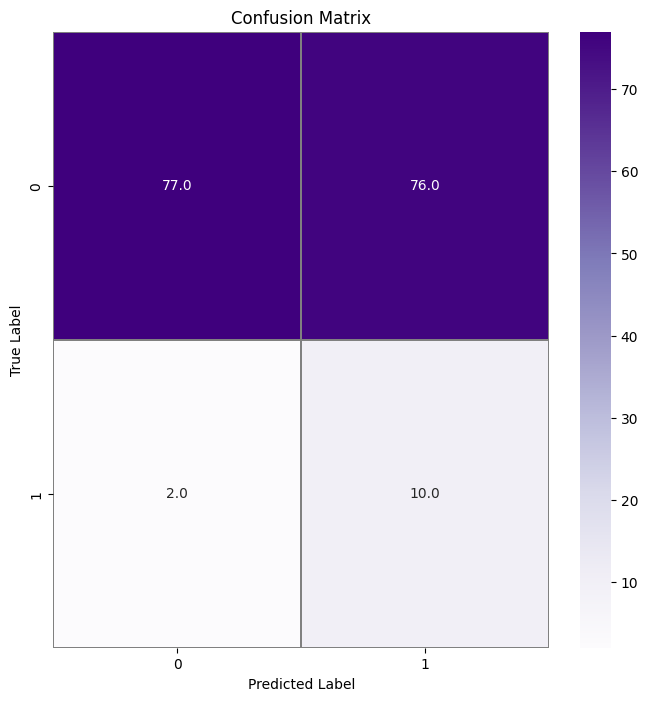

              precision    recall  f1-score   support

           0       0.97      0.50      0.66       153
           1       0.12      0.83      0.20        12

    accuracy                           0.53       165
   macro avg       0.55      0.67      0.43       165
weighted avg       0.91      0.53      0.63       165

       Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet50-no-TL  0.62                      0.2      0.53         0.83   

   Specificity   PPV   NPV   PLR   NLR  
0          0.5  0.12  0.97  1.68  0.33  


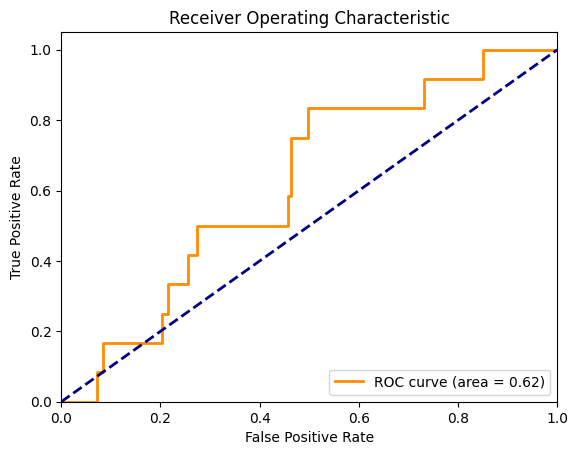

In [44]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-no-TL')

### Without class weights

In [45]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='N')

# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


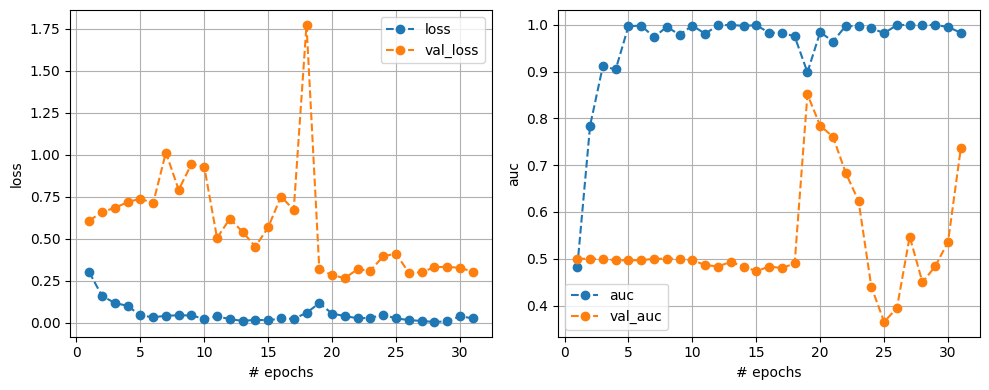

24/24 [==============================] - 6s 232ms/step - loss: 0.0278 - auc: 0.9830 - val_loss: 0.3059 - val_auc: 0.7367
Training time: 265.2561376094818 seconds


In [46]:
# Entrenamiento de la red
resnet_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_checkpoint = ModelCheckpoint('resnet50_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_callback, resnet_checkpoint, resnet_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.04 with F1-score: 0.37


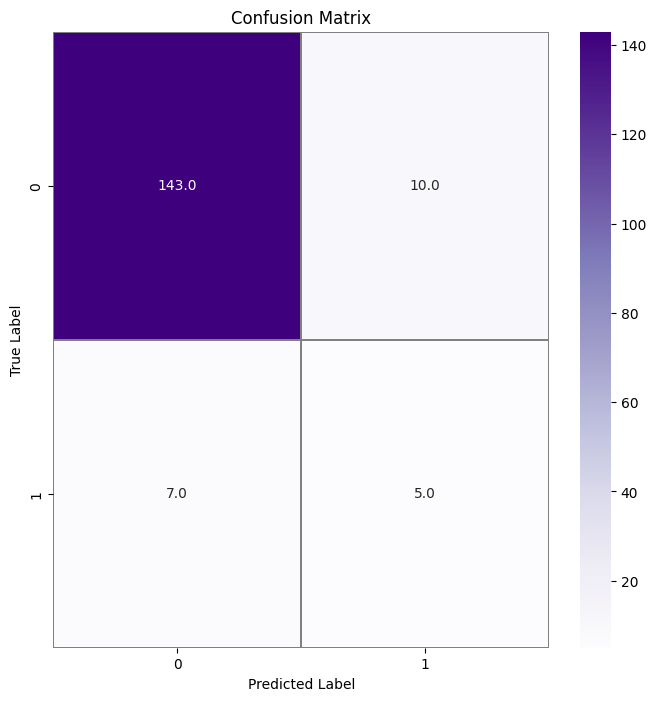

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       153
           1       0.33      0.42      0.37        12

    accuracy                           0.90       165
   macro avg       0.64      0.68      0.66       165
weighted avg       0.91      0.90      0.90       165

             Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet50-no-TL-no-CW  0.71                     0.37       0.9         0.42   

   Specificity   PPV   NPV   PLR   NLR  
0         0.93  0.33  0.95  6.38  0.62  


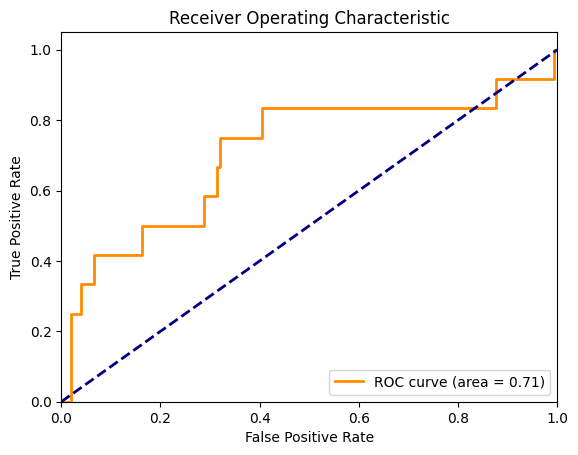

In [47]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-no-TL-no-CW')

# RESNET50 TRANSFER LEARNING

### With class weights

In [48]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='Y')

# Model summary
model_resnet50.summary()

base_model.trainable set to False
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23589791 (8

In [49]:
# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

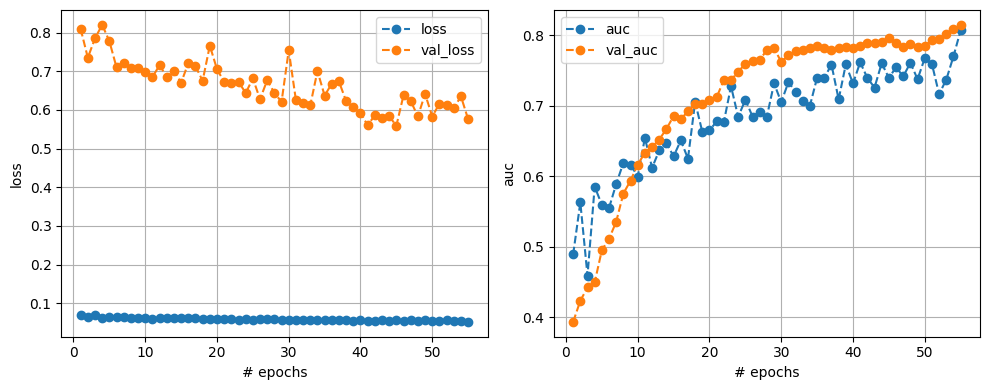

24/24 [==============================] - 6s 212ms/step - loss: 0.0520 - auc: 0.8071 - val_loss: 0.5760 - val_auc: 0.8150
Training time: 381.445672750473 seconds


In [50]:
# Entrenamiento de la red
resnet_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_tl_checkpoint = ModelCheckpoint('resnet50_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_tl_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_tl_callback, resnet_tl_checkpoint, resnet_tl_plot_callback],
                    class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.64 with F1-score: 0.29


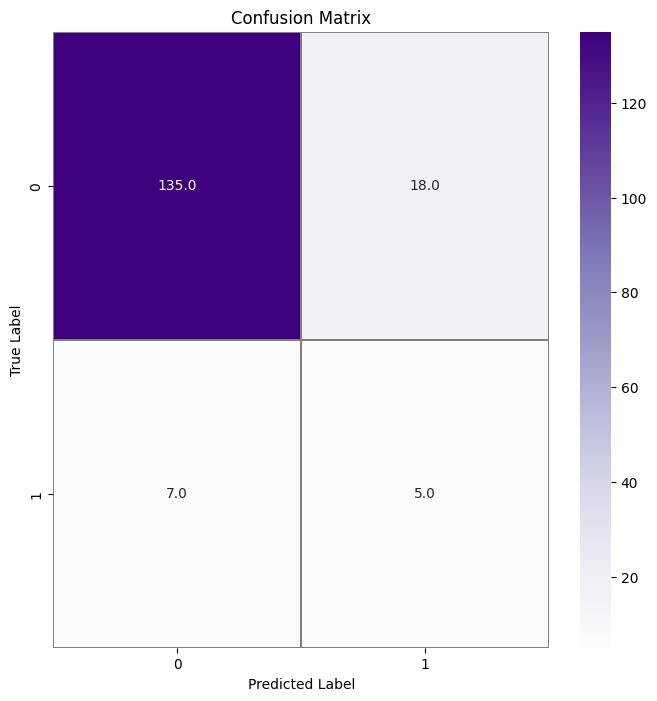

              precision    recall  f1-score   support

           0       0.95      0.88      0.92       153
           1       0.22      0.42      0.29        12

    accuracy                           0.85       165
   macro avg       0.58      0.65      0.60       165
weighted avg       0.90      0.85      0.87       165

    Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet50-TL  0.67                     0.29      0.85         0.42   

   Specificity   PPV   NPV   PLR   NLR  
0         0.88  0.22  0.95  3.54  0.66  


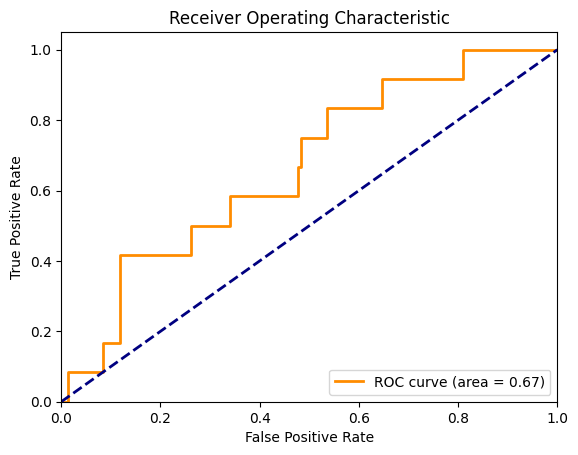

In [51]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-TL')

### Without class weights

In [52]:
# cargar modelo
base_model_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model_resnet50 = build_model(base_model=base_model_resnet50, transfer_learning='Y')

# Compilación de la red
model_resnet50.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


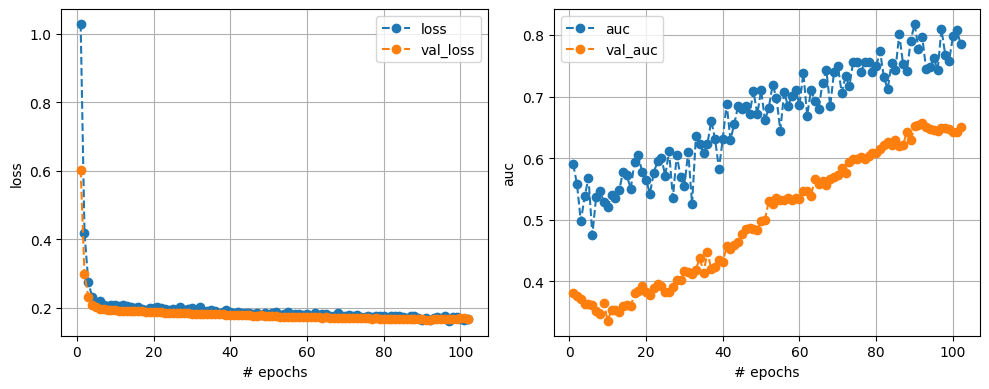

24/24 [==============================] - 7s 233ms/step - loss: 0.1688 - auc: 0.7852 - val_loss: 0.1678 - val_auc: 0.6500
Training time: 757.9130063056946 seconds


In [53]:
# Entrenamiento de la red
resnet_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
resnet_tl_checkpoint = ModelCheckpoint('resnet50_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
resnet_tl_plot_callback = PlotLearning()

start = time.time()

history = model_resnet50.fit(train_data_augmented, 
                    epochs=150, 
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data, 
                    callbacks=[resnet_tl_callback, resnet_tl_checkpoint, resnet_tl_plot_callback],
                    #class_weight=class_weights_dict
                   )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.07 with F1-score: 0.29


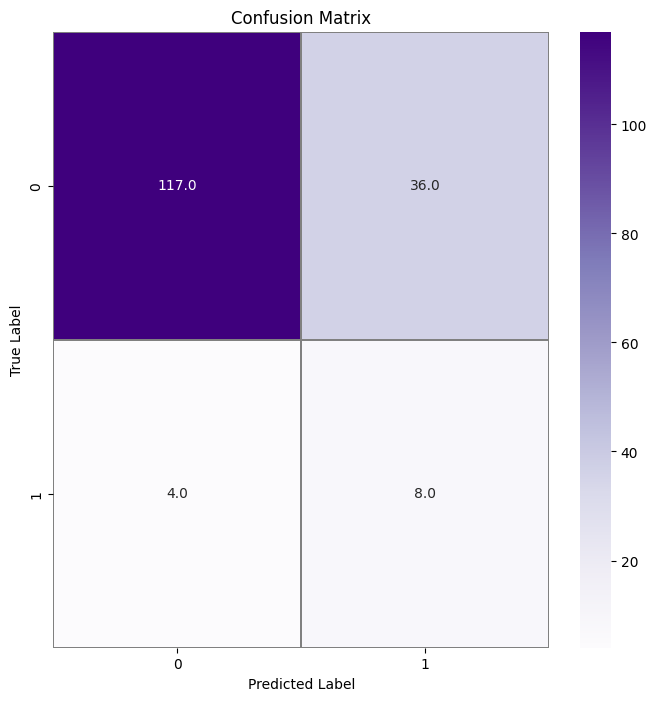

              precision    recall  f1-score   support

           0       0.97      0.76      0.85       153
           1       0.18      0.67      0.29        12

    accuracy                           0.76       165
   macro avg       0.57      0.72      0.57       165
weighted avg       0.91      0.76      0.81       165

          Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet50-TL-no-CW  0.76                     0.29      0.76         0.67   

   Specificity   PPV   NPV   PLR   NLR  
0         0.76  0.18  0.97  2.83  0.44  


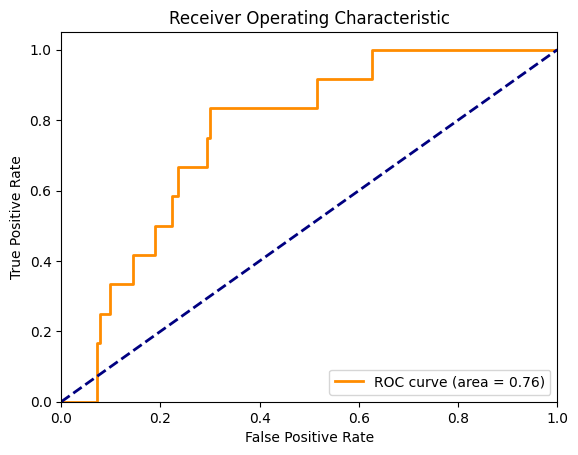

In [54]:
get_model_metrics(test_data=prep_test_data, model=model_resnet50, model_name='ResNet50-TL-no-CW')

# MobileNet (no TL)

In [55]:
from tensorflow.keras.applications import MobileNet

In [56]:
def preprocess_data_mobilenet(image, label):
    # Preprocess the image for MobileNet
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label

# Map the preprocessing function to the datasets
prep_train_data = train_data.map(preprocess_data_mobilenet)
prep_val_data = val_data.map(preprocess_data_mobilenet)
prep_test_data = test_data.map(preprocess_data_mobilenet)


In [57]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [58]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='N')

# model summary
model_mobilenet.summary()

17225924/17225924 [==============================] - 0s 0us/step
base_model.trainable set to True
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_8  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)          

In [59]:
# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

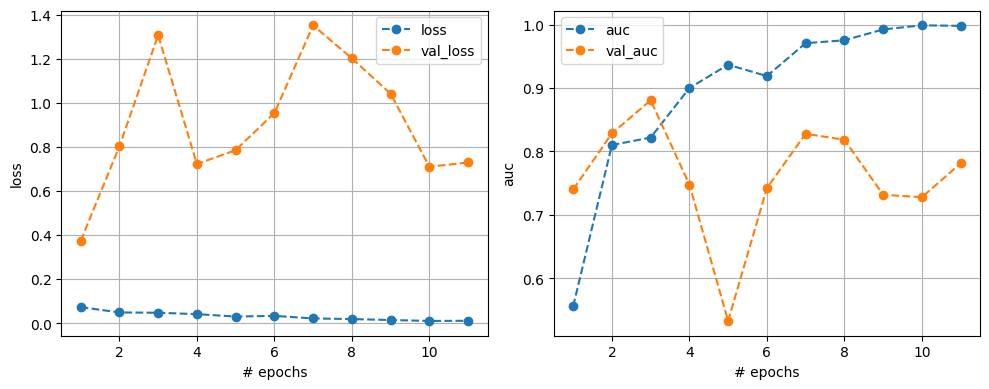

24/24 [==============================] - 4s 139ms/step - loss: 0.0110 - auc: 0.9979 - val_loss: 0.7295 - val_auc: 0.7811
Training time: 62.635518312454224 seconds


In [60]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.74 with F1-score: 0.29


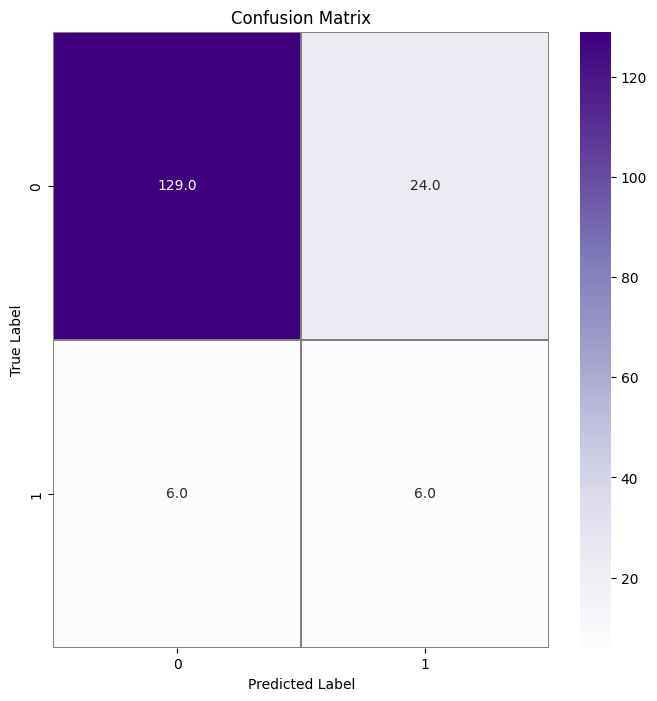

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       153
           1       0.20      0.50      0.29        12

    accuracy                           0.82       165
   macro avg       0.58      0.67      0.59       165
weighted avg       0.90      0.82      0.85       165

        Model Name  AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  MobileNet-no-TL  0.7                     0.29      0.82          0.5   

   Specificity  PPV   NPV   PLR   NLR  
0         0.84  0.2  0.96  3.19  0.59  


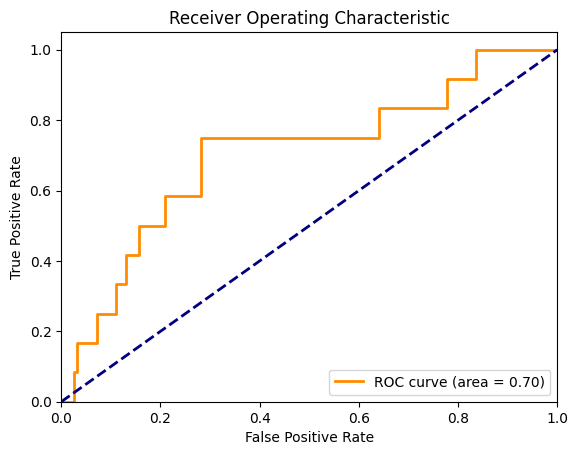

In [61]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-no-TL')

### Without class weights

In [62]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='N')

# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


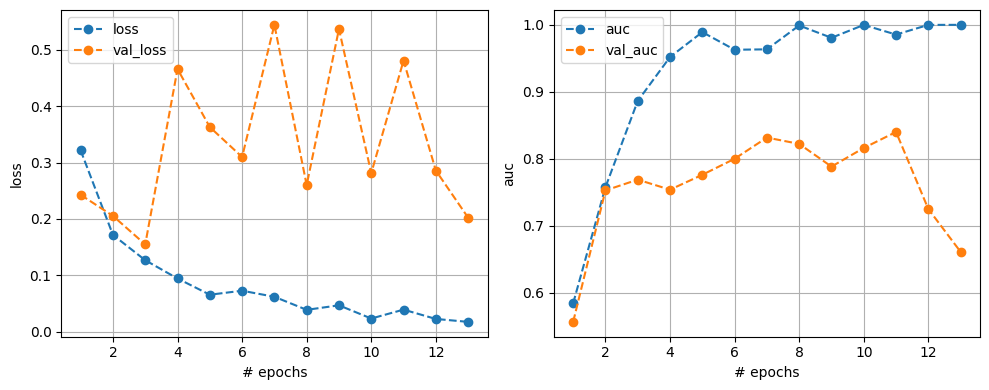

24/24 [==============================] - 4s 144ms/step - loss: 0.0173 - auc: 0.9998 - val_loss: 0.2022 - val_auc: 0.6611
Training time: 69.03240728378296 seconds


In [63]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    #class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.13 with F1-score: 0.25


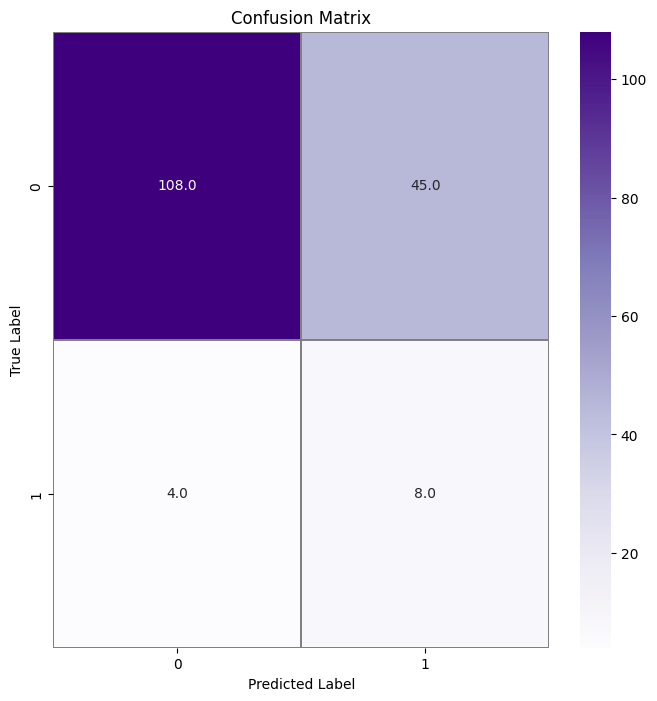

              precision    recall  f1-score   support

           0       0.96      0.71      0.82       153
           1       0.15      0.67      0.25        12

    accuracy                           0.70       165
   macro avg       0.56      0.69      0.53       165
weighted avg       0.91      0.70      0.77       165

              Model Name   AUC  F1-Score Positive Class  Accuracy  \
0  MobileNet-no-TL-no-CW  0.67                     0.25       0.7   

   Sensitivity  Specificity   PPV   NPV   PLR   NLR  
0         0.67         0.71  0.15  0.96  2.27  0.47  


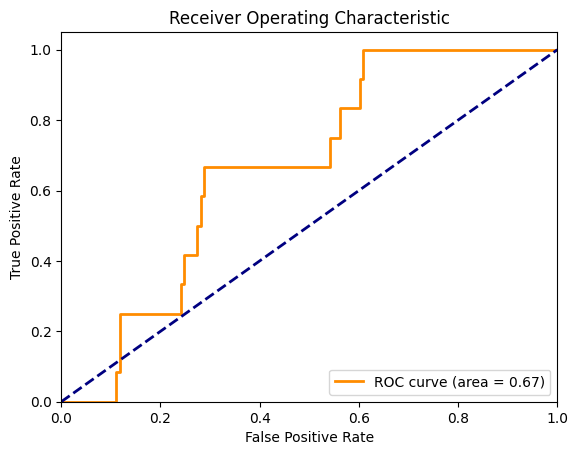

In [64]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-no-TL-no-CW')

# MobileNet (TL)

### With class weights

In [65]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y')

# model summary
model_mobilenet.summary()

base_model.trainable set to False
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 grayscale_input (InputLaye  [(None, 224, 224, 1)]     0         
 r)                                                              
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
 0 (GlobalAveragePooling2D)                                      
                                                                 
 dense_14 (Dense)            (None, 1)                 1025      
                        

In [66]:
# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

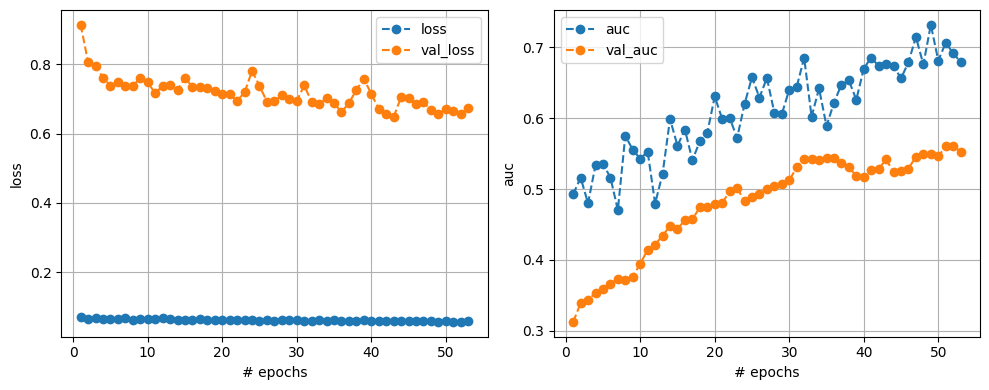

24/24 [==============================] - 4s 134ms/step - loss: 0.0588 - auc: 0.6791 - val_loss: 0.6735 - val_auc: 0.5522
Training time: 228.30558943748474 seconds


In [67]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.59 with F1-score: 0.20


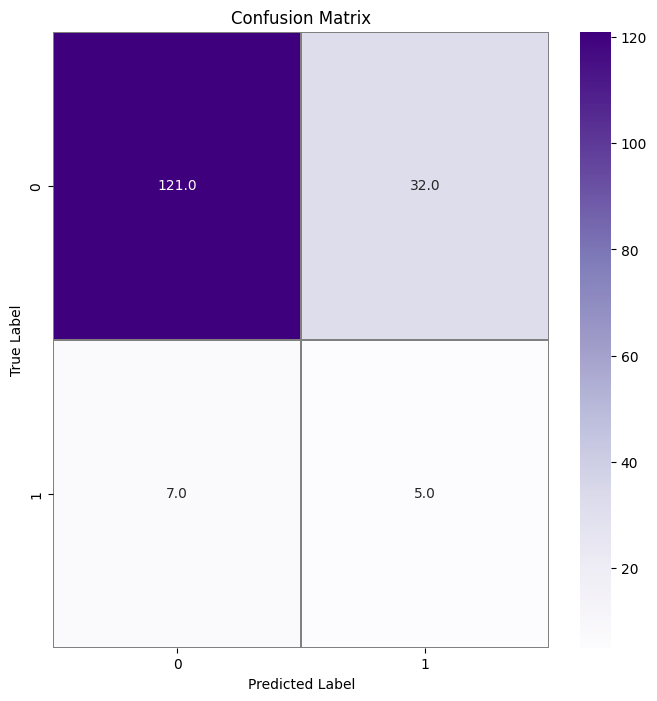

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       153
           1       0.14      0.42      0.20        12

    accuracy                           0.76       165
   macro avg       0.54      0.60      0.53       165
weighted avg       0.89      0.76      0.81       165

     Model Name  AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  MobileNet-TL  0.6                      0.2      0.76         0.42   

   Specificity   PPV   NPV   PLR   NLR  
0         0.79  0.14  0.95  1.99  0.74  


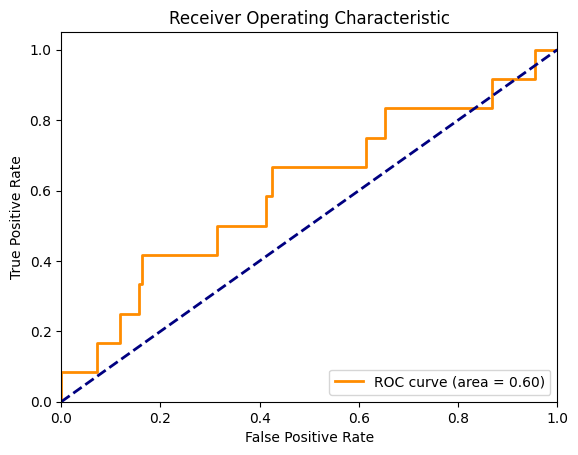

In [68]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-TL')

### Without class weights

In [69]:
# load the model
base_mobilenet = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# build the model
model_mobilenet = build_model(base_model=base_mobilenet, transfer_learning='Y')

# Compilación de la red
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


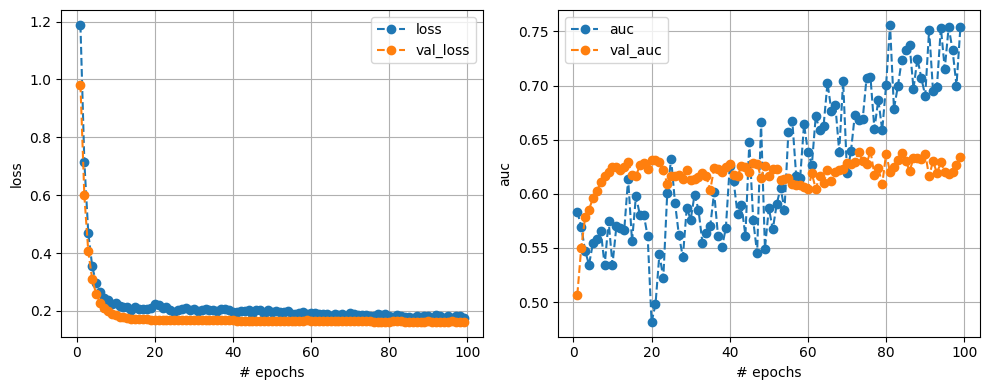

24/24 [==============================] - 4s 133ms/step - loss: 0.1761 - auc: 0.7541 - val_loss: 0.1625 - val_auc: 0.6344
Training time: 417.93145394325256 seconds


In [70]:
# Entrenamiento de la red
mob_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
mob_checkpoint = ModelCheckpoint('mob_best_weights.h5', save_best_only=True, save_weights_only=True)
mob_plot_callback = PlotLearning()

start = time.time()

history = model_mobilenet.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[mob_callback, mob_checkpoint, mob_plot_callback],
                    #class_weight=class_weights_dict
                    )

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.09 with F1-score: 0.34


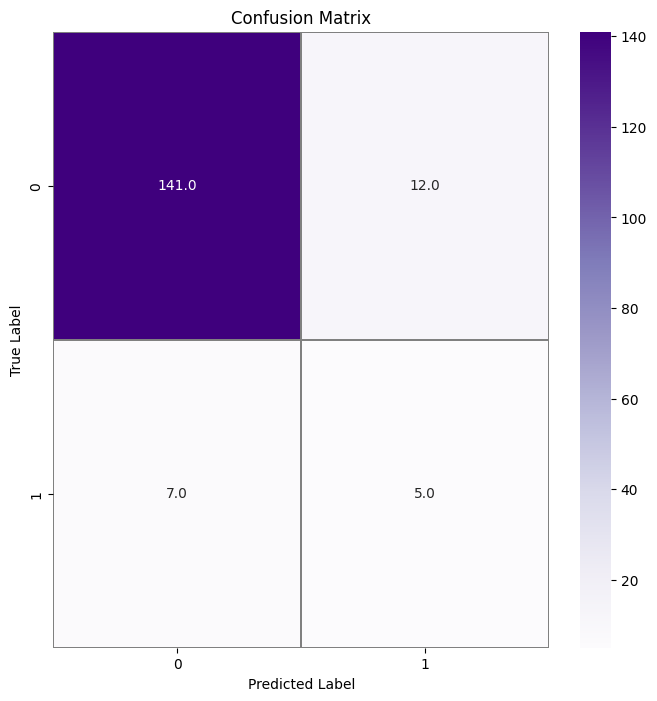

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       153
           1       0.29      0.42      0.34        12

    accuracy                           0.88       165
   macro avg       0.62      0.67      0.64       165
weighted avg       0.90      0.88      0.89       165

           Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  MobileNet-TL-no-CW  0.73                     0.34      0.88         0.42   

   Specificity   PPV   NPV   PLR   NLR  
0         0.92  0.29  0.95  5.31  0.63  


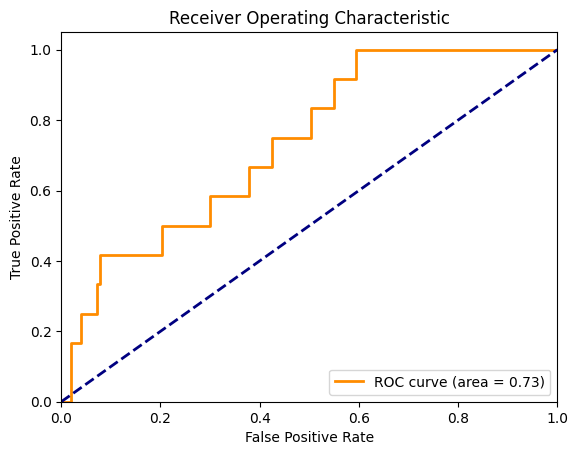

In [71]:
get_model_metrics(test_data=prep_test_data, model=model_mobilenet, model_name='MobileNet-TL-no-CW')

# ResNet18 (no TL)

In [72]:
!pip install image-classifiers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00


In [73]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

In [74]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

prep_train_data = train_data.map(preprocess_data_resnet18)
prep_val_data = val_data.map(preprocess_data_resnet18)
prep_test_data = test_data.map(preprocess_data_resnet18)

In [75]:
train_data_augmented = prep_train_data.map(augment_image)

### With class weights

In [76]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='N')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

44920640/44920640 [==============================] - 0s 0us/step
base_model.trainable set to True


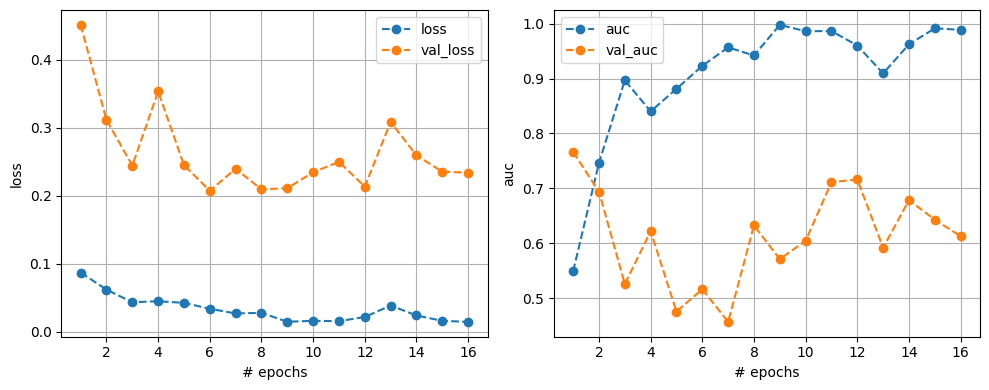

24/24 [==============================] - 4s 136ms/step - loss: 0.0144 - auc: 0.9886 - val_loss: 0.2337 - val_auc: 0.6128


In [77]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=class_weights_dict
                    )

Best threshold: 0.01 with F1-score: 0.19


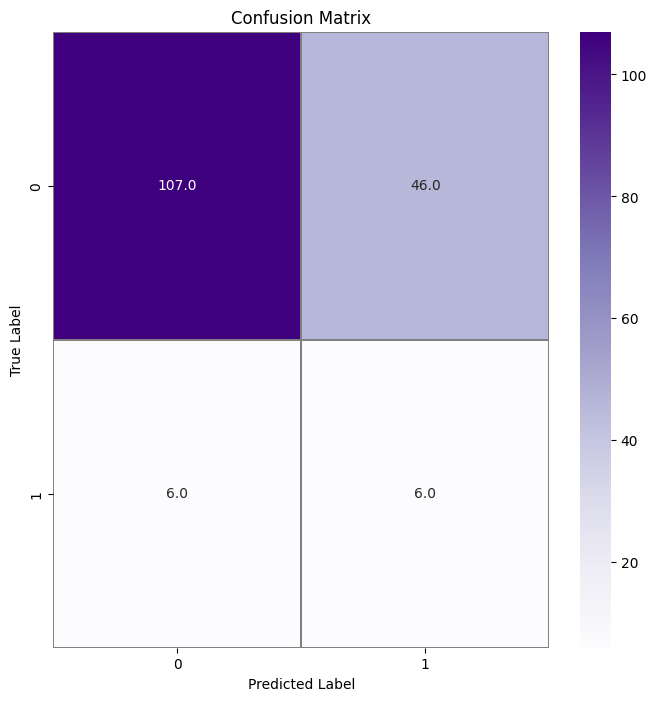

              precision    recall  f1-score   support

           0       0.95      0.70      0.80       153
           1       0.12      0.50      0.19        12

    accuracy                           0.68       165
   macro avg       0.53      0.60      0.50       165
weighted avg       0.89      0.68      0.76       165

       Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-no-TL  0.57                     0.19      0.68          0.5   

   Specificity   PPV   NPV   PLR   NLR  
0          0.7  0.12  0.95  1.66  0.71  


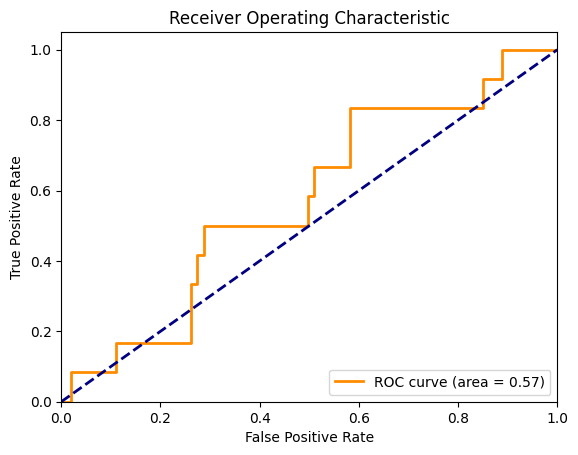

In [78]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL')

### Without class weights

In [79]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='N')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to True


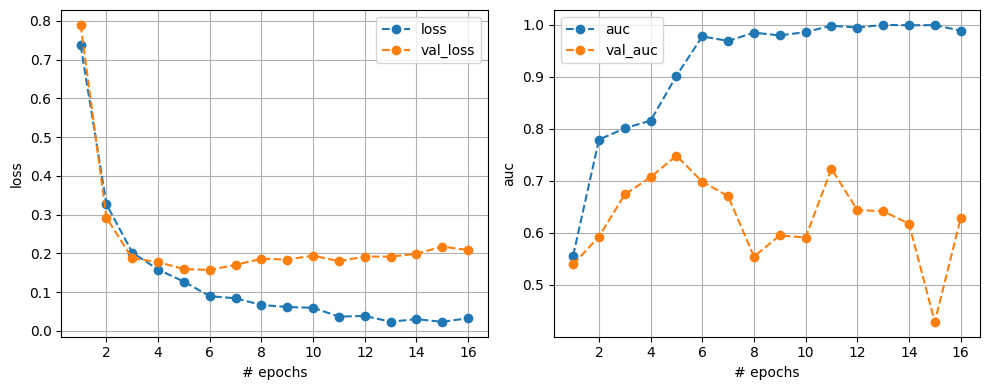

24/24 [==============================] - 5s 179ms/step - loss: 0.0328 - auc: 0.9889 - val_loss: 0.2086 - val_auc: 0.6278


In [80]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    #class_weight=class_weights_dict
                    )

Best threshold: 0.01 with F1-score: 0.23


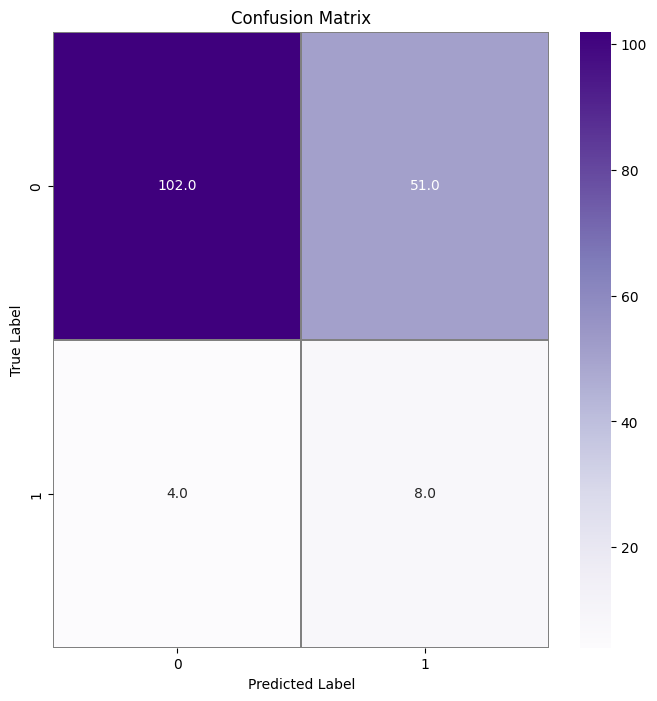

              precision    recall  f1-score   support

           0       0.96      0.67      0.79       153
           1       0.14      0.67      0.23        12

    accuracy                           0.67       165
   macro avg       0.55      0.67      0.51       165
weighted avg       0.90      0.67      0.75       165

             Model Name  AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-no-TL-no-CW  0.7                     0.23      0.67         0.67   

   Specificity   PPV   NPV  PLR  NLR  
0         0.67  0.14  0.96  2.0  0.5  


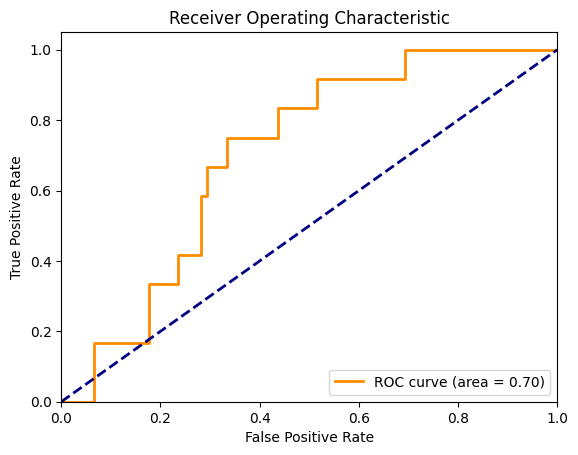

In [81]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL-no-CW')

# ResNet18 (TL)

### With class weights

In [82]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


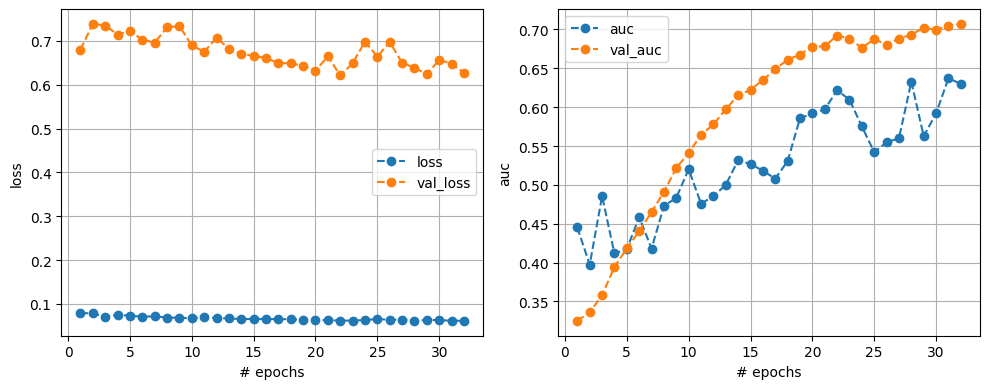

24/24 [==============================] - 4s 135ms/step - loss: 0.0615 - auc: 0.6300 - val_loss: 0.6265 - val_auc: 0.7072


In [83]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=class_weights_dict
                    )

Best threshold: 0.49 with F1-score: 0.19


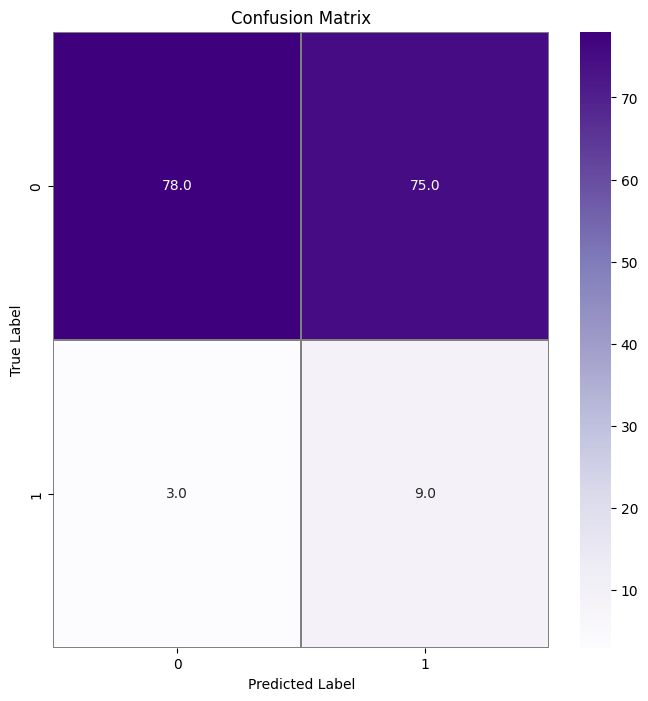

              precision    recall  f1-score   support

           0       0.96      0.51      0.67       153
           1       0.11      0.75      0.19        12

    accuracy                           0.53       165
   macro avg       0.54      0.63      0.43       165
weighted avg       0.90      0.53      0.63       165

    Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-TL  0.58                     0.19      0.53         0.75   

   Specificity   PPV   NPV   PLR   NLR  
0         0.51  0.11  0.96  1.53  0.49  


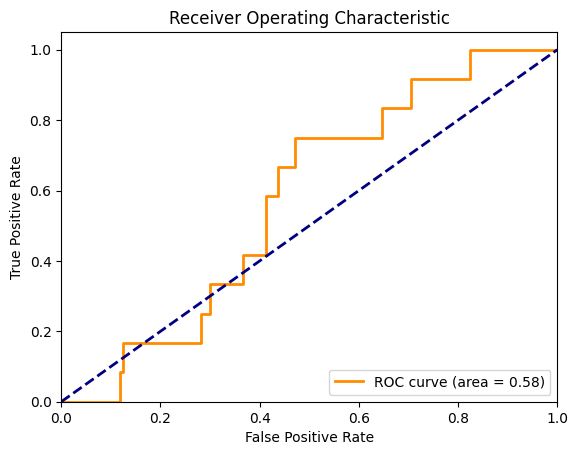

In [84]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-TL')

### Without class weights

In [85]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')

# Compilación de la red
model_resnet18.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=METRICS)

base_model.trainable set to False


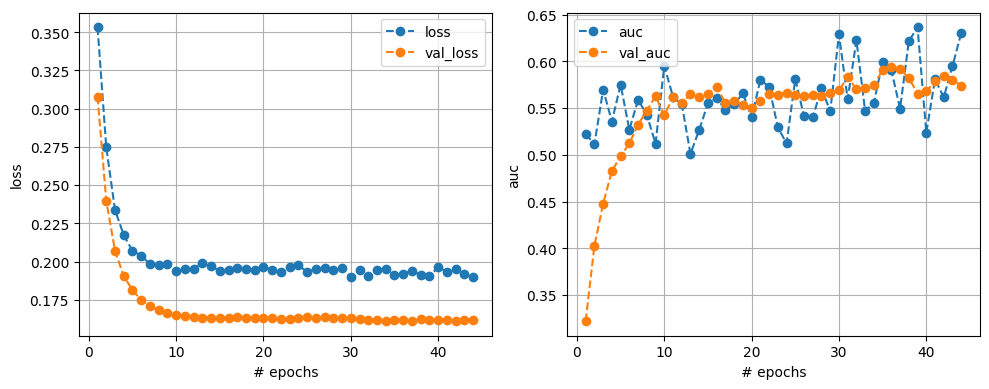

24/24 [==============================] - 4s 130ms/step - loss: 0.1898 - auc: 0.6303 - val_loss: 0.1618 - val_auc: 0.5739


In [86]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(train_data),
                    validation_data=prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    #class_weight=class_weights_dict
                    )

Best threshold: 0.04 with F1-score: 0.18


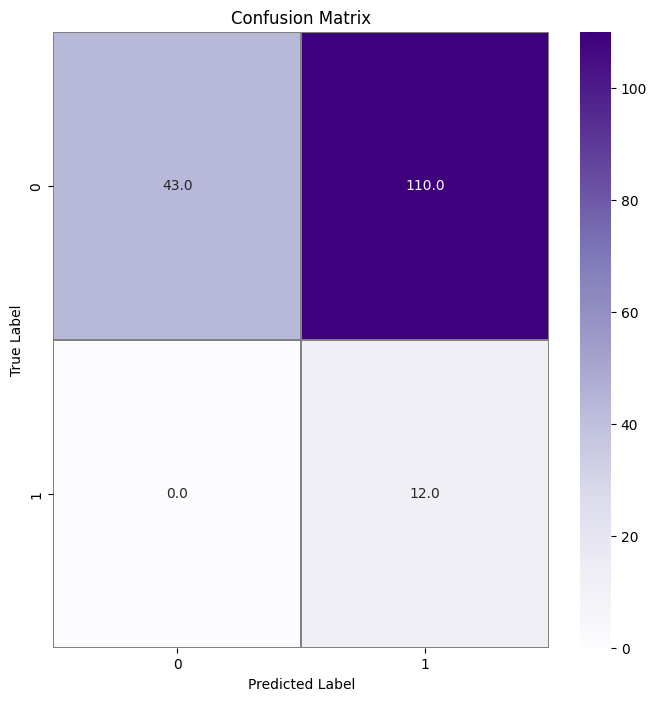

              precision    recall  f1-score   support

           0       1.00      0.28      0.44       153
           1       0.10      1.00      0.18        12

    accuracy                           0.33       165
   macro avg       0.55      0.64      0.31       165
weighted avg       0.93      0.33      0.42       165

          Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-TL-no-CW  0.66                     0.18      0.33          1.0   

   Specificity  PPV  NPV   PLR  NLR  
0         0.28  0.1  1.0  1.39  0.0  


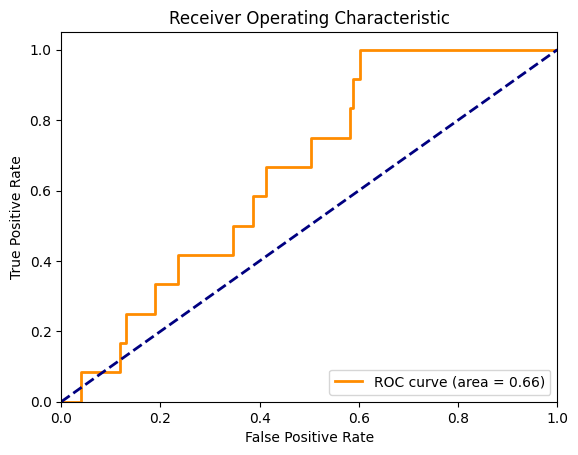

In [87]:
get_model_metrics(test_data=prep_test_data, model=model_resnet18, model_name='ResNet18-TL-no-CW')